In [1]:
"""
Created on Thu Feb  1 17:53:51 2018

@author: Jie Wang

The steps of the project are the following:

# Using Histogram of oriented gradients (HOG) and Color to extract image features 

# Train the Linear SVM classifier using the extracted features and labels

# Sliding search of the cars using the trained SVM classier 

# Remove multiple detections and false positives using "heat" 

# Test on video

# Combine with the lane detections pipeline  

Most of the functions are directly come from the class lectures and notes 
"""
#%%
import os
import glob
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import time
from sklearn.svm import LinearSVC

from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label

import pickle 
from collections import deque

%matplotlib inline

C:\Anaconda3\envs\carnd-term1\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#%%

# =================================================================================
# STEP 0: read in images 
# =================================================================================

# images are divided up into vehicles and non-vehicles
cars = []
notcars = []

car_img_path = ["vehicles\GTI_Far", "vehicles\GTI_Left", "vehicles\GTI_MiddleClose",
                "vehicles\GTI_Right", "vehicles\KITTI_extracted"]
notcar_img_path = ["non-vehicles\Extras", "non-vehicles\GTI"]

for path in car_img_path:
    car_path = os.path.join(path, "*.png")
    for car in glob.glob(car_path):
        cars.append(car)
        
for path in notcar_img_path:
    notcar_path = os.path.join(path, "*.png")
    for notcar in glob.glob(notcar_path):
        notcars.append(notcar)


In [3]:
#%%
# =================================================================================
# STEP 1: Using HOG and Color to extract image features 
# =================================================================================

# The following function codes come from Lecutre 34. Search and Classify (lesson_function.py)
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                image = image * 255
                image = image.astype(np.uint8)
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2Luv)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


In [1]:
#%%
# =================================================================================
# STEP 2: Train the Linear SVM classifier using the extracted features and labels
# =================================================================================    

# Tweak these parameters and see how the results change.    
color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# Stack arrays in sequence vertically (row wise)
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
# Stack arrays in sequence horizontally (column wise)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a n_predict sample
t=time.time()
n_predict = 10
print('The SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('for ', n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print('Used ', round(t2-t, 5), 'seconds to predict', n_predict,'samples')

# save SVM training results 
SVM_pickle = {}
SVM_pickle["X_scaler"] = X_scaler
SVM_pickle["svc"] = svc
pickle.dump(SVM_pickle, open( "test_images/SVM_pickle_2.p", "wb" ))

C:\Anaconda3\envs\carnd-term1\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Using: 11 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 7284
12.76 Seconds to train SVC...
Test Accuracy of SVC =  0.9938
The SVC predicts:  [ 1.  1.  0.  1.  0.  1.  0.  1.  0.  0.]
for  10 labels:  [ 1.  1.  0.  1.  0.  1.  0.  1.  0.  0.]
Used  0.01 seconds to predict 10 samples


In [4]:
#%%
# =================================================================================
# STEP 3: Sliding search of the cars using the trained SVM classier 
# ================================================================================= 

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images

### The reason to define a function for list of images "extract_features()" is for TRAINING 
### The reason to define a function for a single image "single_img_features()" is for searching on each video frame (a sigle image)  
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            img = img * 255
            img = img.astype(np.uint8)
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2Luv)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

# print multi-scale windows
def multi_scale_windows(image, svc, X_scaler, xy_window_list, y_start_stop):
        
    windows_mul = []
    for i in range (len(xy_window_list)):
        windows_search = slide_window(image, x_start_stop=[650, None], y_start_stop=y_start_stop[i], 
                        xy_window=xy_window_list[i], xy_overlap=(0.8, 0.8))
        windows_mul.append(windows_search)
    
    windows_final = sum(windows_mul, [])
    
    color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    spatial_size = (16, 16) # Spatial binning dimensions
    hist_bins = 16    # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off
    
    hot_windows = search_windows(image, windows_final, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       
        
    return hot_windows



In [5]:

#%%   
# =================================================================================
# STEP 4: Remove multiple detections and false positives using "heat"
# ================================================================================= 
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

#heat = np.zeros_like(image[:,:,0]).astype(np.float)


In [6]:
"""
To store the heatmaps I suggest using collections.deque, in this way you do not need to delete 
the oldest heatmap. The simplest way to implement this is using multi-frame accumulated heatmap:
just store the heatmap of the last N frames (N can be 5 or 8) and do the same thresholding and 
labelling on the sum (or average) of these heatmaps.
"""

n_frames = 5    
heatmaps = deque(maxlen = n_frames) #You can choose how many frames to use.

def draw_windows(image):

    # test list of windows to improve computation 
    xy_window_list = [(96,96), (128,128)]
    y_start_stop = [[380, 650], [380, None]] # Min and max in y to search in slide_window()
    
    # load SVM trained classifier
    SVM_pickle = pickle.load(open( "test_images/SVM_pickle2.p", "rb" ))
    X_scaler = SVM_pickle["X_scaler"]
    svc = SVM_pickle["svc"]

    hot_windows = multi_scale_windows(image, svc, X_scaler, xy_window_list, y_start_stop)
   
    #Create a frame_heatmap
    frame_heatmap = np.zeros_like(image[:,:,0])
    
    frame_heatmap = add_heat(frame_heatmap, hot_windows)
    
    heatmaps.append(frame_heatmap)
    
    combined = sum(heatmaps)
    
    # Apply threshold
    frame_heatmap = apply_threshold(combined, 6)

    # Find final boxes from heatmap using label function
    labels = label(frame_heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    return draw_img    

C:\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


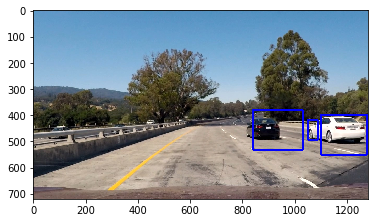

In [7]:
image = mpimg.imread('test_images/test1.jpg')
draw_image = draw_windows(image)
plt.imshow(draw_image)

In [8]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

counter = 0

# test video for quick test
#output = 'test_output1.mp4'
#clip1 = VideoFileClip("test_video.mp4")

# 16 - 21 sec for false detection test   T = 26 works well  
#output = 'project_output1621.mp4'
#clip1 = VideoFileClip("project_video.mp4").subclip(16,21)

# 22 - 30 for far white car detection test  T = 16 no, 8 yes, 12 no, 9 barely, 6 ok 
#output = 'project_output2527.mp4'
#clip1 = VideoFileClip("project_video.mp4").subclip(23,30)

# full test
output = 'project_car.mp4'
clip1 = VideoFileClip("project_video.mp4")

output_clip = clip1.fl_image(draw_windows) 
%time output_clip.write_videofile(output, audio=False)

print(counter)
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

[MoviePy] >>>> Building video project_car.mp4
[MoviePy] Writing video project_car.mp4


100%|███████████████████████████████████▉| 1260/1261 [1:49:47<00:04,  4.38s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_car.mp4 

Wall time: 1h 49min 48s
0


## Combing the Lane Detection Pipeline

In [9]:
# Refer to:
# https://github.com/jwangjie/SDC-Advanced-Lane-Lines

# ====================
# CAMERA CALIBRATION
# ====================

objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal\calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    # Convert images to grayscale in order to use cv2.findChessboardCorners
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)

def cal_undistort(img, objpoints, imgpoints):
    img_size = (img.shape[1], img.shape[0])
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    
    return dst

# ========================
# Color/gradient threshold
# ========================

# hls color threshold
def hls_white_yellow_binary(img):
    # Transfer the RGB to HLS (mpimg.imread was used)
    hls_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    hls_yellow_binary = np.zeros_like(hls_img[:,:,2])
    hls_yellow_binary[(hls_img[:,:,2] >= 90) & (hls_img[:,:,2] <= 255)] = 1

    hls_white_binary = np.zeros_like(hls_img[:,:,1])
    hls_white_binary[(hls_img[:,:,1] >= 200) & (hls_img[:,:,1] <= 255)] = 1
    
    # Now combine both
    hls_binary = np.zeros_like(hls_img[:,:,1])
    hls_binary[(hls_yellow_binary == 1) | (hls_white_binary == 1)] = 1

    return hls_binary

#%%
# gradient threshold
def abs_sobel_thresh(img, sobel_kernel=3, orient='x', thresh=(0, 255)):

    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # Return the result
    return binary_output

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):

    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8-bit (0 - 255) and convert to type np.uint8
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1
    # Return the binary image
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):

    # Calculate the x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # Return the binary image
    return binary_output

# combine all gradient thresholding 
def combined_gradient(img):    
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements    
    # # apply gradient threshold on grayscale image 
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(50, 225))
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(50, 225))
    mag_binary = mag_thresh(gray, sobel_kernel=ksize, thresh=(20, 150))
    dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(0.7, 1.3))
    
    grad_combined = np.zeros_like(dir_binary)
    grad_combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    return grad_combined

# combine hls and gradient thresholding 
def combined_binary(img):
    hls_bin = hls_white_yellow_binary(img)
    grad_combined = combined_gradient(img)
    
    combined_bin = np.zeros_like(grad_combined)
    combined_bin[(grad_combined == 1) | (hls_bin == 1)] = 1
    
    return combined_bin 
    
# =====================
# Perspective transform
# =====================

# define calibration box in source (orignial) and destionation (desired or warped) coordinate
src_pts = np.array([[690, 450], [1110,img.shape[0]-2],[210,img.shape[0]-2], [595, 450]], np.int32)
dst_pts = np.array([[1000,0], [1000,img.shape[0]-2],[200,img.shape[0]-2], [200, 0]], np.int32)

# define perspective tranform function
def warp(img, src_pts, dst_pts, flag = False):
   
    # four source coordinates
    src = src_pts.astype(np.float32)
    #four desired coordinates
    dst = dst_pts.astype(np.float32) 
    
    # compute the perspective transform matrix M for 2d images
    if flag == False:
        M = cv2.getPerspectiveTransform(src, dst)
        # create warped image using linear interpolation
        img_size = (img.shape[1], img.shape[0])
        
    # compute the perspective transform matrix M for 3d images
    elif flag == True:
        M = cv2.getPerspectiveTransform(dst, src)
        # create warped image using linear interpolation
        img_size = (img.shape[:2][1], img.shape[:2][0])
    
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped

# =====================
# Detect Lane Lines
# =====================
def window_sliding(warped_im):
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(warped_im[warped_im.shape[0]//2:,:], axis=0)

    # This method comes from 
    # https://discussions.udacity.com/t/unable-to-draw-rectangles-on-curve-on-images/244276/61?u=jiewang
    warped_im = np.uint8(warped_im) 
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((warped_im, warped_im, warped_im))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint]) # np.argmax returns the indices of the maximum values along an axis
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(warped_im.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped_im.nonzero() # np.nonzero return the indices of the elements that are non-zero.
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped_im.shape[0] - (window+1)*window_height
        win_y_high = warped_im.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds) # np.concatenate join a sequence of arrays along an existing axis
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    return left_lane_inds, right_lane_inds, leftx, lefty, rightx, righty, nonzerox, nonzeroy

# Visualization
def poly_fit(leftx, lefty, rightx, righty, warped_im):
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, warped_im.shape[0]-1, warped_im.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fit, right_fit, left_fitx, right_fitx

# =============================
# Calculation of Lane Curvature
# =============================
def car_movement(left_fitx, right_fitx, warped_im):
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    ploty = np.linspace(0, warped_im.shape[0]-1, warped_im.shape[0] )
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # average radius of curvature is in meters
    rad_curverad = (left_curverad + right_curverad)/2
    
    # calculate the car offset
    line_ave = np.mean(((right_fitx) + (left_fitx))/2)
    line_offset = line_ave - (warped_im.shape[-1]//2)
    car_offset = line_offset * xm_per_pix
    
    return rad_curverad, car_offset

def fixed_frame(warped_im, undist_test_imgs, left_fitx, right_fitx):
    
    ploty = np.linspace(0, warped_im.shape[0]-1, warped_im.shape[0] )

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_im).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp =  warp(color_warp, src_pts, dst_pts, flag = True)
    # Combine the result with the original image
    fix_img = cv2.addWeighted(undist_test_imgs, 1, newwarp, 0.3, 0)
    rad_curverad, car_offset = car_movement(left_fitx, right_fitx, warped_im)
    
    car_offset = 'Car Offset: ' + '{0:.2f}'.format(car_offset) + 'm'
    rad_curverad = 'Curvature Radius:' + '{0:.2f}'.format(rad_curverad) + 'm'
    
    cv2.putText(fix_img, car_offset , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), thickness=2)
    cv2.putText(fix_img, rad_curverad , (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), thickness=2)
    
    return fix_img

def video_pipeline(img):
    
    # undistored, color and gradient thresholding mask, and warped images processing
    undist_test_imgs = cal_undistort(img, objpoints, imgpoints)
    combined_bin = combined_binary(undist_test_imgs)
    warped_im = warp(combined_bin, src_pts, dst_pts, flag = False)
    
    # windows sliding line searching 
    left_lane_inds, right_lane_inds, leftx, lefty, rightx, righty, nonzerox, nonzeroy = window_sliding(warped_im)
    # polynomial fitting 
    left_fit, right_fit, left_fitx, right_fitx = poly_fit(leftx, lefty, rightx, righty, warped_im)
    # line drawing
    fixed_img = fixed_frame(warped_im, undist_test_imgs, left_fitx, right_fitx)
    
    return fixed_img 

In [10]:
def lane_car_detection(img):
    line_det = video_pipeline(img)
    car_line_det = draw_windows(line_det)
    return car_line_det

In [11]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

counter = 0
output = 'project_laneCar.mp4'
clip1 = VideoFileClip("project_video.mp4")

#output = 'test_laneCar_output1.mp4'
#clip1 = VideoFileClip("test_video.mp4")
output_clip = clip1.fl_image(lane_car_detection) 
%time output_clip.write_videofile(output, audio=False)

print(counter)
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

[MoviePy] >>>> Building video project_laneCar.mp4
[MoviePy] Writing video project_laneCar.mp4


100%|███████████████████████████████████▉| 1260/1261 [2:22:12<00:07,  7.20s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_laneCar.mp4 

Wall time: 2h 22min 13s
0
